In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.cuda.amp import autocast, GradScaler
from torch.cuda.amp import autocast
from joblib import load

In [2]:
class LSTM_Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, seq_len):
        super(LSTM_Autoencoder, self).__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, input_size)
        self.hidden_size = hidden_size
        self.seq_len = seq_len

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        encoded, (hn, cn) = self.encoder(x, (h0, c0))
        decoded, _ = self.decoder(encoded, (hn, cn))
        decoded = self.output_layer(decoded)
        
        return decoded

In [3]:
def pipeline(data_recs, data_columns,):
    for idx, data_rec in enumerate(data_recs):
        print(f"Processing record {idx + 1}...")

        data_rec = pd.DataFrame([data_rec], columns=data_columns)

        missing_values = data_rec.isnull().sum()
        if len(missing_values[missing_values > 0]):
            print(missing_values[missing_values > 0])
            data_rec.fillna(0, inplace=True)
        else:
            print('There are no missing values in the record')

        for i in range(1, 21):
            if data_rec.iloc[0, i] not in [0, 1]:
                print(f"Invalid value in column {i}. Assigned value: 0")
                data_rec.iloc[0, i] = 0

        for i in range(21, 23):
            if (data_rec.iloc[0, i] < 1) or (data_rec.iloc[0, i] > 27):
                print(f"Invalid value in column {i}. Assigned value: 1")
                data_rec.iloc[0, i] = 1

        print('Checked for invalid values and imputed the same')
        print('Using the LSTM Encoder, Standard scaler and Reconstruction Errors to check if the record is an anomaly')

        if 'Unnamed: 0' in data_rec.columns:
            data_rec = data_rec.drop(['Unnamed: 0'], axis=1)

        input_size = 25  
        hidden_size = 256
        seq_len = 1

        model_path = "./House A files/lstm_autoencoder_ha.pth"
        scaler_path = "./House A files/standardscaler_ha.joblib"
        reconstruction_error_path = "./House A files/reconstruction_errors_ha.npy"

        device = torch.device('cpu')
        model = LSTM_Autoencoder(input_size=input_size, hidden_size=hidden_size, seq_len=seq_len)

        state_dict = torch.load(model_path, map_location=device)
        if any(key.startswith("module.") for key in state_dict.keys()):
            state_dict = {key[len("module."):]: value for key, value in state_dict.items()}

        try:
            model.load_state_dict(state_dict)
        except RuntimeError as e:
            print(f"Error loading model: {e}")
            print("Ensure the model architecture matches the saved state_dict structure.")

        model.eval()

        reconstruction_errors = np.load(reconstruction_error_path)
        threshold = np.percentile(reconstruction_errors, 95)

        sc = load(scaler_path)
        new_data = sc.transform(data_rec)
        new_data_tensor = torch.tensor(new_data, dtype=torch.float32).unsqueeze(0).to(device)

        with torch.no_grad():
            new_data_reconstructed = model(new_data_tensor)
            reconstruction_error = torch.mean((new_data_tensor - new_data_reconstructed) ** 2).item()

        print("Error: ",reconstruction_error,"Threshold: ",threshold)
        is_anomaly = reconstruction_error > threshold
        if is_anomaly:
            print(f"Record {idx + 1}: Current Record is an anomaly\n")
        else:
            print(f"Record {idx + 1}: Current Record is not an anomaly\n")

In [4]:
import warnings
warnings.filterwarnings("ignore")

# houseA = pd.read_csv("../Aras/house_a_combined_dataset.csv")

data_columns = ["Unnamed: 0",'photocell_wardrobe', 'photocell_couch', 'ir_tv_receiver',
       'force_couch_1', 'force_couch_2', 'distance_chair_1',
       'distance_chair_2', 'photocell_fridge', 'photocell_kitchen_drawer',
       'photocell_wardrobe_2', 'photocell_bathroom_cabinet',
       'contact_house_door', 'contact_bathroom_door', 'contact_shower_door',
       'sonar_hall', 'sonar_kitchen', 'distance_tap', 'distance_water_closet',
       'temperature_kitchen', 'force_bed', 'Resident1', 'Resident2', 'Hour',
       'Week', 'Day Of Week']

data_recs = [[0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,12,17,0,0,0], # Wrong day and week passed
             [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,12,17,0,1,1], # Possible day and week passed
             [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,14,1,1], #Both resident are out and some senor is active
             [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,11,11,14,1,1], #Both resident sleeping and house door is open
             [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,12,11,14,1,1]] #Residents are watching TV or sleeping but kitchen temperature sensor is active 

pipeline(data_recs, data_columns)

Processing record 1...
There are no missing values in the record
Checked for invalid values and imputed the same
Using the LSTM Encoder, Standard scaler and Reconstruction Errors to check if the record is an anomaly
Error:  0.0003835099923890084 Threshold:  0.00016964174574241042
Record 1: Current Record is an anomaly

Processing record 2...
There are no missing values in the record
Checked for invalid values and imputed the same
Using the LSTM Encoder, Standard scaler and Reconstruction Errors to check if the record is an anomaly
Error:  0.00014498601376544684 Threshold:  0.00016964174574241042
Record 2: Current Record is not an anomaly

Processing record 3...
There are no missing values in the record
Checked for invalid values and imputed the same
Using the LSTM Encoder, Standard scaler and Reconstruction Errors to check if the record is an anomaly
Error:  0.0005591337103396654 Threshold:  0.00016964174574241042
Record 3: Current Record is an anomaly

Processing record 4...
There are

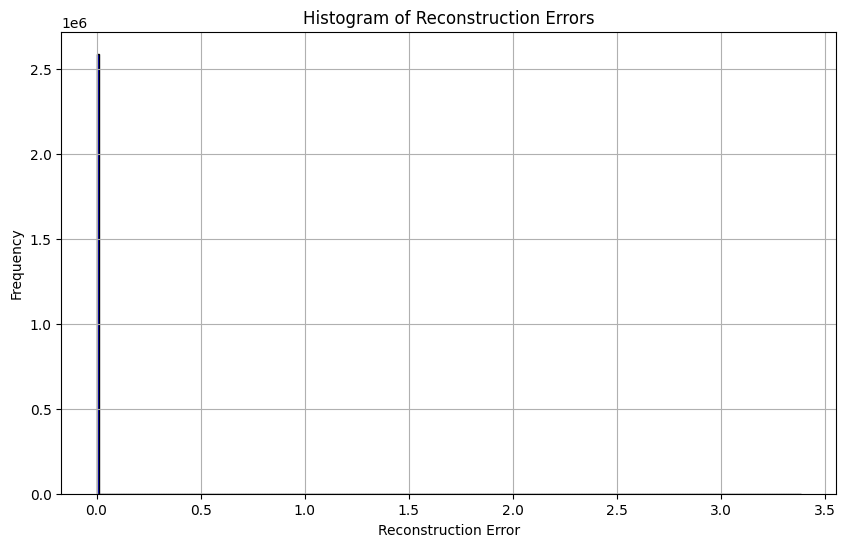

In [25]:
import matplotlib.pyplot as plt
import numpy as np

reconstruction_errors = np.load("../Pipeline/House A files/reconstruction_errors_ha.npy")

plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors,bins = 300 ,color='blue', edgecolor='black')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

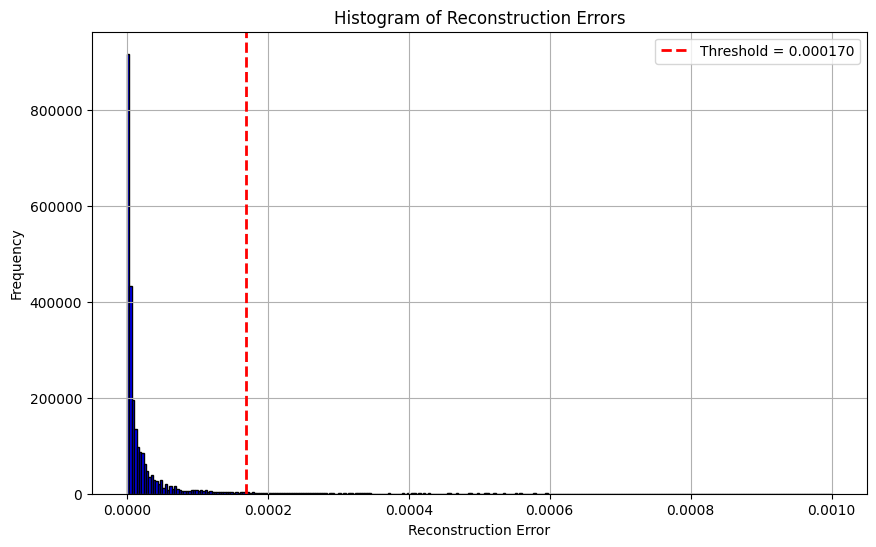

In [35]:
import matplotlib.pyplot as plt
import numpy as np

filtered_reconstruction_errors = reconstruction_errors[reconstruction_errors < 0.001]

threshold = np.percentile(reconstruction_errors, 95)

plt.figure(figsize=(10, 6))
plt.hist(filtered_reconstruction_errors, bins=300, color='blue', edgecolor='black')

plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold = {threshold:.6f}')

plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()

plt.show()
